# SQLAlchemy Homework - Surfs Up!

In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
# Explore Database
inspector = inspect(engine)

# Using the inspector to print the column names within the 'measurement' table and its types
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# Using the inspector to print the column names within the 'station' table and its types
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])


id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date).first()

('2010-01-01')

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Calculate the date 1 year ago from the last data point in the database .

# Starting from the last data point in the database. 
last_date =session.query(func.max(Measurement.date)).scalar()
last_date

'2017-08-23'

In [13]:
# Calculate the date one year from the last date in data set.
last_date_year_ago = dt.datetime.strptime(last_date,'%Y-%m-%d') - dt.timedelta(days=365)
last_date_year_ago = last_date_year_ago.strftime('%Y-%m-%d')
last_date_year_ago

'2016-08-23'

In [14]:
# Perform a query to retrieve the data and precipitation scores
query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= last_date_year_ago).all()

In [15]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(query,columns=['date', 'precipitation'])
precipitation_df.set_index('date', inplace=True)
precipitation_df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


In [16]:
# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by='date',ascending=True)
precipitation_df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


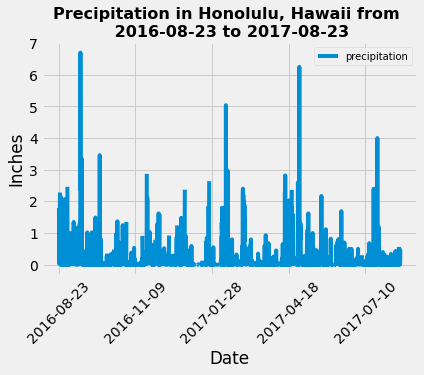

In [17]:
# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(rot=45)
plt.title(f"Precipitation in Honolulu, Hawaii from \n {last_date_year_ago} to {last_date}",fontsize=16, fontweight = 'bold')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.legend(loc='upper right', prop={'size':10})
plt.savefig("Images/OneYearPrecipitation.png")
plt.show()

In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [19]:
# Design a query to calculate the total number stations in the dataset
number_stations=session.query(Measurement.station.distinct()).count()
print(f'There is a total of {number_stations} stations.')

There is a total of 9 stations.


In [20]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
stations = [Station.station, func.count(Measurement.station)]
most_active_stations = session.query(*stations).filter(Station.station == Measurement.station).group_by(Station.station).\
                            order_by(func.count(Measurement.station).desc()).all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [21]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = most_active_stations[0][0]
temperature = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.\
                            avg(Measurement.tobs)).filter(Measurement.station == most_active_station).all()

#display temperature highs and lows
print(F"Low Temp: {temperature[0][0]}, High Temp: {temperature[0][1]}, Average Temp: {temperature[0][1]}")

Low Temp: 54.0, High Temp: 85.0, Average Temp: 85.0


In [22]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_year = session.query(Measurement.tobs).\
                   filter(Measurement.date.between(last_date_year_ago,last_date),\
                   Measurement.station == most_active_station).all()

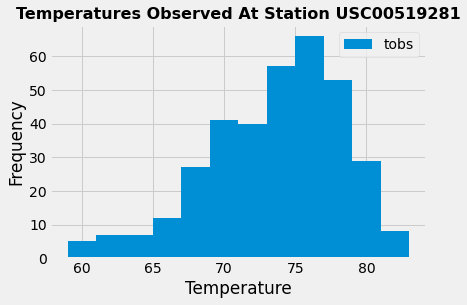

In [23]:
# Plot the results as a histogram
plt.figure
plt.hist(np.ravel(temperature_year), bins=12)
plt.title(f'Temperatures Observed At Station {most_active_stations[0][0]}',fontsize=16, fontweight = 'bold')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(['tobs'], loc = 'upper right')

plt.savefig("Images/StationHistogram.png")
plt.show()

# Close session

In [24]:
# Close Session
session.close()